# Introduction

The NBA-games dataset is a really great dataset with lots of information about players, teams and results that can be put together in order to create a predictive model for future games. I found this project very interesting as I really like basketball 🏀🏀🏀 and there was room to play around and experiment with the data. The main focus of the notebook is to create a dataset for predictive modelling and at a second step to trim it down to few features in order to enhance interpretability. Let's get started! 🎈🎈🎈

In [1]:
import numpy as np
import pandas as pd
import re
import warnings

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
!pip install adjustText
from adjustText import adjust_text
from textwrap import wrap

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from eli5.sklearn import PermutationImportance
from catboost import Pool, cv, CatBoostClassifier
from sklearn.metrics import  classification_report, log_loss, roc_auc_score
import shap  

pd.set_option('display.max_columns', None)

games = pd.read_csv('../input/nba-games/games.csv')
details = pd.read_csv('../input/nba-games/games_details.csv')
teams = pd.read_csv('../input/nba-games/teams.csv')
players = pd.read_csv('../input/nba-games/players.csv')
ranking = pd.read_csv('../input/nba-games/ranking.csv')

details['PLAYER_NAME_SHORT'] = details['PLAYER_NAME'].str.replace('^(.).*\s(.*)', '\\1.\\2')
details[["MINS", "SECS"]] = details.MIN.str.extract(r"([^:]+):(.*)")
details.loc[(~details.MIN.str.contains(':', na = True)), 'SECS'] = details.MIN
details.MINS = pd.to_numeric(details.MINS)
details.SECS = pd.to_numeric(details.SECS)
details['PLAY_TIME'] = np.round(details.MINS.fillna(0) + details.SECS/60)

games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] #Leaving one entry per game
games['GAME_DATE_EST'] = pd.to_datetime(games.GAME_DATE_EST)


  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7098 sha256=5d51de50551c50bc384efe1fe35866c07496c4220d9f527c064deb846241335a
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


The default value of regex will change from True to False in a future version.


# EDA
We have 5 datasets at our disposal:
* Games -> Information about each game and the stats of the teams playing
* Games details -> More detailed information about the individual player stats
* Players -> Information about the name of the player and his team
* Ranking -> Information about the standings of each team on individual days throughout the season
* Teams --> Information about the team including ownership, arena, when it was established etc.

For the EDA we are mainly going to focus on the details dataset in order to have a more granular viewpoint.  Specifically, the focus will be on the yearly stats of the players and how we can use PCA and KMEANS to visualise the differences between individual player performances.

## PCA
The details dataset contains many variables that can be used for analysis. Naturally, some variable combinations might be more interesting than others or offer more unique insights.  
For a more hollistic view of the data though, we can perform Principal Components Analysis.  
The aim of the analysis is to reduce the individual player stats into 2 components and try to see if these components can be interpreted meaningfully.

In [2]:
def get_season(date):
    '''
    Returns the season based on the month and year of a date
    '''
    date = pd.to_datetime(date, format='%Y-%m-%d')
    if (date.month >= 10):
        season = date.year
    else:
        season = date.year - 1
    return season

def get_season_data(season):
    ''' 
    Aggregates the details data into yearly figures
    Returns the aggregated data and the standardised aggregated data    
    '''
    
    temp = details.loc[details.GAME_ID.isin(games.loc[games.SEASON == season, 'GAME_ID'])]
    temp = temp.loc[~temp['PLAY_TIME'].isnull()]
    agg_df = temp.groupby(['PLAYER_ID', 'PLAYER_NAME', 'PLAYER_NAME_SHORT'])[['FGA', 'FGM', 'FG3A', 'FG3M', 'FTA', 'FTM', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLAY_TIME']].sum().reset_index()
    agg_df = agg_df.loc[agg_df['PLAY_TIME'] >= 1500].reset_index(drop = True)
    st_agg_df = StandardScaler().fit_transform(agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']))
    return(agg_df, st_agg_df)

pca = PCA(n_components = 2)
agg_df, st_agg_df = get_season_data(2020)
pcomp = pca.fit_transform(st_agg_df)
df = pd.DataFrame(pca.components_, 
             index = ['PC 1', 'PC 2'],
             columns = agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']).columns).round(2)
styles = [dict(selector="caption", props=[("caption-side", "bottom")])]
df.style.set_table_styles(styles).set_properties(**{'font-size':'8pt'}).background_gradient('Greens').set_precision(2).set_caption('Breakdown of the principal components for the 2020 season')


,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,AST,STL,BLK,TO,PF
PC 1,0.40,0.40,0.16,0.15,0.38,0.38,0.01,0.20,0.32,0.16,-0.02,0.40,0.11
PC 2,-0.10,0.03,-0.42,-0.42,0.12,0.06,0.49,0.36,-0.07,-0.04,0.42,0.04,0.27


Looking more closely at the values, it becomes clear that the first principal component is more oriented towards offence (as FG, FT, TO and AST are the most important contributors) while the second principal component is more defence oriented (OREB, DREB, BLK and PF contribute the most).

Let's see which players score the highest in each of the components.

In [3]:
def pca_plots(season, ax = None):
    '''
    Performs PCA on season data
    Calculates the top players based on the 2 PCs
    Creates a scatter plot for visualising the season data
    '''
    
    pca = PCA(n_components = 2)
    agg_df, st_agg_df = get_season_data(season)
    pcomp = pca.fit_transform(st_agg_df)
    
    overall = pcomp.sum(axis = 1)
    top_overall = np.argpartition(overall, -4)[-4:]
    top_pc1 = np.argpartition(pcomp[:,0], -4)[-4:]
    top_pc2 = np.argpartition(pcomp[:,1], -4)[-4:]
    top_pc = list(set(list(top_pc1) + list(top_pc2) + list(top_overall)))

    alphas = np.zeros(pcomp.shape[0]) + 0.3
    alphas[top_pc] = 1
    
    ax.scatter(pcomp[:, 0], pcomp[:, 1], alpha = alphas)
    ax.axhline(y = 0, color ='green', linestyle='--', lw=1)
    ax.axvline(x = 0, color ='green', linestyle='--', lw=1)
    texts = [ax.text(x=pcomp[i, 0],y=pcomp[i, 1],s=agg_df.PLAYER_NAME_SHORT[i]) for i in top_pc]
    adjust_text(texts, ax = ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    _ = ax.set_title(str(season))
    

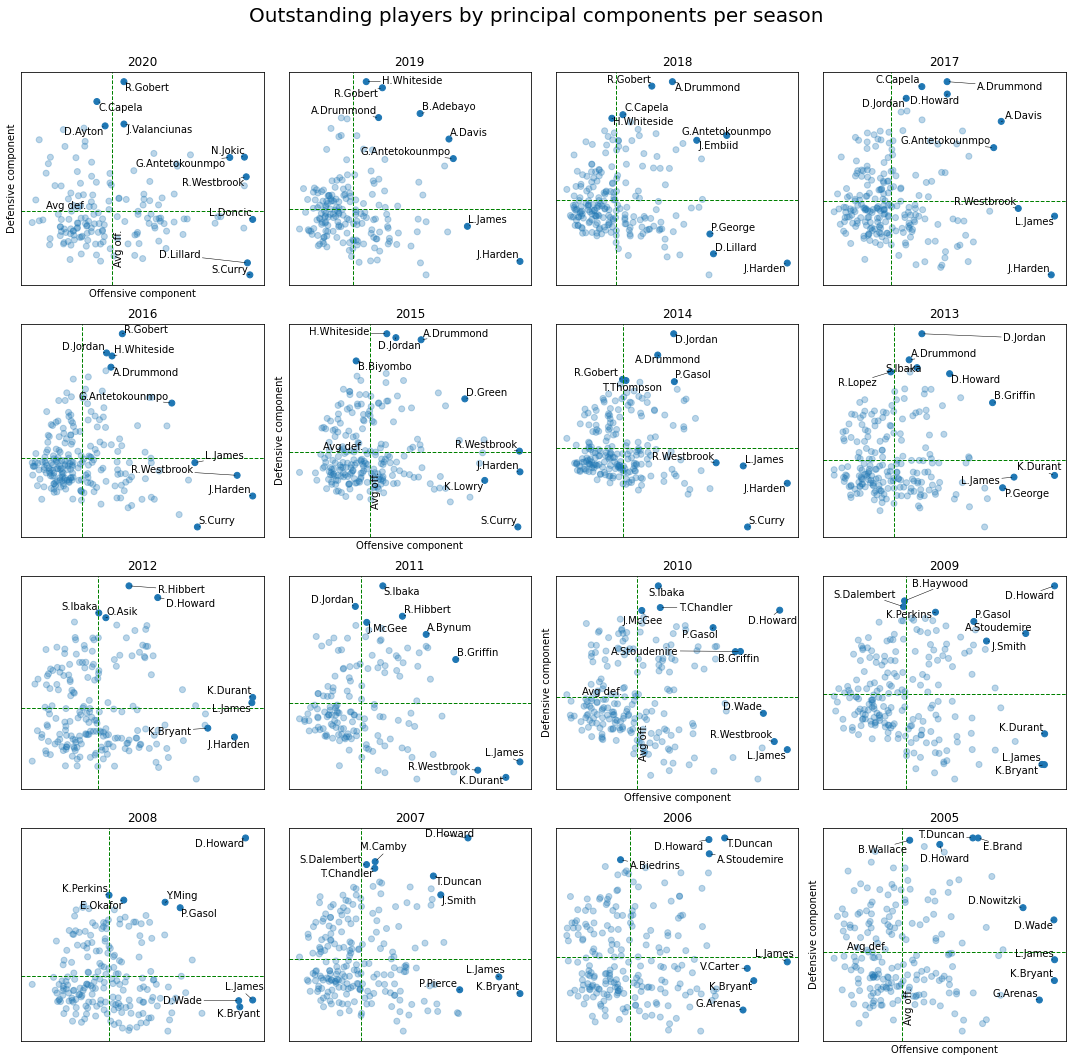

In [4]:
fig,axes = plt.subplots(4, 4, figsize=(15,15))
for i,season in enumerate(range(games.SEASON.max(), games.SEASON.min()+1, -1)):
    pca_plots(season, ax = axes.ravel()[i])    
    axes.ravel()[i].tick_params(bottom=False, left=False, labelbottom = False, labelleft = False)
    if (i % 5 == 0 ):
        axes.ravel()[i].set_xlabel('Offensive component')
        axes.ravel()[i].set_ylabel('Defensive component')
        axes.ravel()[i].text(x = 0.1, y = -3, s = 'Avg off.',rotation=90)
        axes.ravel()[i].text(x = -3, y = 0.1, s = 'Avg def.')
fig.suptitle('Outstanding players by principal components per season', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

Indeed the interpretation of the principal components seems to be correct.  
For example in the 2019 season the offensive machine that is James Harden, scores the highest for the first component (but not very well on the defensive side😅) while the defensive component is dominated by players such as Gobert, Whiteside and Drummond.  
Players such as Giannis, Davis and Adebayo offer the best of both worlds!

### How many principal components are enough?
Using 2 principal components allows for an easy and interpretable visualisation but is not necessarily the optimal number of components.  
We can assess how 'complete' is the breakdown into principal components by visualising what percentage of the total dataset variance is captured.

In [5]:
pca_all = PCA()
pca_all.fit(st_agg_df)

cum_var = np.cumsum(pca_all.explained_variance_ratio_)
cum_var = np.insert(cum_var, 0, 0)
cum_var = cum_var[:-1]

comp = [str(x + 1) for x in range(pca_all.n_components_)]

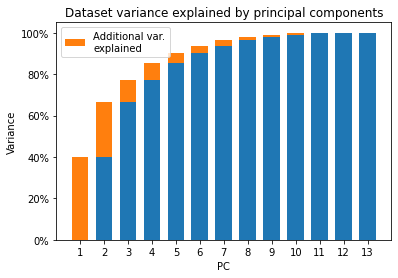

In [6]:
fig, ax = plt.subplots()

ax.bar(comp, cum_var, align='center', width=0.7, label='_nolegend_')
ax.bar(comp, pca_all.explained_variance_ratio_, bottom=cum_var, align='center', width=0.7, label= '\n'.join(wrap('Additional var. explained', 20)))

ax.set_ylabel('Variance')
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.set_xlabel('PC')
ax.set_title('Dataset variance explained by principal components')
ax.legend()

plt.show()

Looking at the chart, it becomes clear that the first two principal components explain roughly 70% of the total dataset variance.  
Therefore, our dimensionality reduction is quite meaningful and indeed distills patterns but there is still some nuance in the data that is not fully captured.

## K-Means

An additional interesting exploratory data visualisation is to try to cluster our dataset. One of the easiest to use clustering algorithms is the KMeans algorithm, which aims to find the most homogenious groups by minimising intra-group variance.  
One of the drawbacks of K-Means is that it the optimal number of clusters is tough to determine. Nevertheless, we are going to visualise the results of K-Means for various cluster sizes and see how they relate to the PC analysis from above.

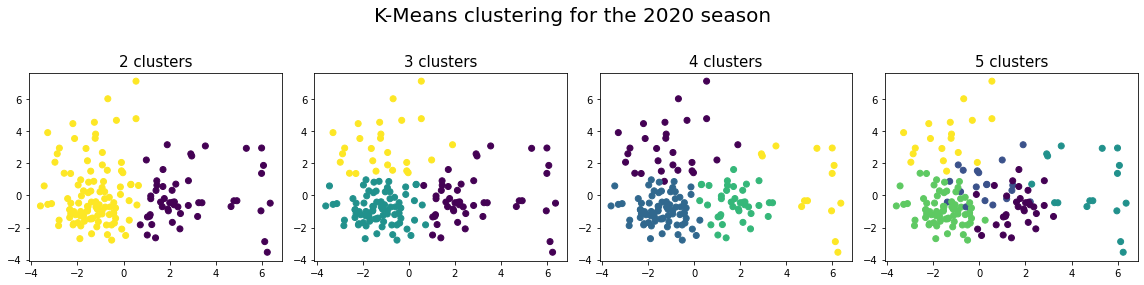

In [7]:
fig,axes = plt.subplots(1, 4, figsize=(16,4))
agg_df, st_agg_df = get_season_data(2020)
for i in range(2,6):
    kmeans = KMeans(n_clusters = i, random_state = 0).fit(st_agg_df)
    axes.ravel()[i-2].scatter(pcomp[:, 0], pcomp[:, 1], c = kmeans.labels_)
    axes.ravel()[i-2].set_title(str(i) + ' clusters', size = 15)
fig.suptitle('K-Means clustering for the 2020 season', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.75)
plt.show()

Interpreting the clustering is very subjective but to my mind they split the dataset into the following groups:   
2 clusters --> Bad offence - Good offence  
3 clusters --> Good offence - Good defence - Rest  
4 clusters --> Great offence - Good defence - Mediocre offence - Rest  
5 clusters --> ????😅  

Clearly the groups for the 5 clusters are tougher to interpret...

# Preparing the predictive modelling dataset

As always, the crucial task when given NBA stats is to manage to predict the outcome of future games based on the already available stats. But while we could use the datasets as they are, it is much better to try to create new meaningful features to help with prediction accuracy.

The modelling dataset consists of the following components:
* Team ELO rating 
* Team record information (wins, losses, percentages)
* Missing players (due to short term injuries)
* Team player efficiency
* Schedule information (whether the team gave back to back games, how many games in the last 5 days)

In [8]:
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])
ranking.sort_values('STANDINGSDATE', inplace = True)
ranking = ranking.loc[ranking.SEASON_ID // 10000 == 2]
ranking['SEASON_ID'] = ranking['SEASON_ID'] % 10000
ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)

# Creating a df with season start and end for excluding preseason and playoff games
start_dates = ranking.loc[ranking.SEASON_ID > 2002].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('FIRST_GAME').reset_index()
t = ranking.loc[(ranking.G == ranking.MAX_S_GAMES)].groupby(['SEASON_ID', 'STANDINGSDATE'])['TEAM_ID'].nunique().to_frame('TEAMS').reset_index()
playoff_dates = t.loc[(t.TEAMS == 30) | 
                      ((t.TEAMS == 28) & (t.SEASON_ID == 2012)) | 
                      ((t.TEAMS == 29) & (t.SEASON_ID == 2003))].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()
dates = start_dates.merge(playoff_dates, how = 'left')
dates.loc[dates.SEASON_ID == 2019, 'LAST_GAME'] = pd.to_datetime('2020-03-12') #Manually adding the end of regular season

# Filtering out details for non-regular season games
details = details.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON']], how = 'left')
details = details.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'left')
details = details.loc[(details.LAST_GAME.isnull()) | ((details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME))]

# Filtering out games for non-regular season games
games = games.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'inner')
games = games.loc[games.LAST_GAME.isnull() | ((games.GAME_DATE_EST <= games.LAST_GAME) & (games.GAME_DATE_EST > games.FIRST_GAME))]
games.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace=True)

# Excluding the 2020 season as it was plagued by Covid related results
details = details.loc[details.SEASON != 2020]
games = games.loc[games.SEASON != 2020]
dates = dates.loc[dates.SEASON_ID != 2020]

# Creating a new ranking df with regular season only and values that can be used for modeling 
ranking_short = ranking[['TEAM_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD']].merge(dates)
ranking_short = ranking_short.loc[(ranking_short.STANDINGSDATE >= ranking_short.FIRST_GAME) & (ranking_short.STANDINGSDATE <= ranking_short.LAST_GAME)]
ranking_short = ranking_short.loc[ranking_short.G > 0]
ranking_short[['HOME_W', 'HOME_L']] = ranking_short.HOME_RECORD.str.split('-', expand = True)
ranking_short[['AWAY_W', 'AWAY_L']] = ranking_short.ROAD_RECORD.str.split('-', expand = True)
ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']].apply(pd.to_numeric)
ranking_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME', 'HOME_RECORD', 'ROAD_RECORD'], inplace = True)
ranking_short.sort_values('STANDINGSDATE', inplace = True)

# Creating a new games df with regular season only
games_short = pd.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS']], dates, left_on = 'SEASON', right_on = 'SEASON_ID')
games_short = games_short.loc[(games_short.GAME_DATE_EST > games_short.FIRST_GAME) & (games_short.GAME_DATE_EST <= games_short.LAST_GAME)]
games_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace = True)
games_short.sort_values('GAME_DATE_EST', inplace = True)

## Calculating ELO for each team

The [ELO statistic](https://en.wikipedia.org/wiki/Elo_rating_system) was originally divised by Arpad Elo for ranking players in chess games. In order to adjust the calculation for NBA games, the methodology was adjusted by [538](https://fivethirtyeight.com/).  
The main points of the calculation:
* Winning a game increases the ELO of the team and losing a game decreases it
* The amount of increase/decrease depends on a) the margin of victory b) the pre-game expectations for the outcome of the game (which are based on the ELO rating of the two teams)
* Ratings are adjusted after each game

One of the easiest way to assess the ELO figures is to have a look at the end-season results and see which teams finished at the top.

In [9]:
def mov_mult(mov, elo_diff):
    return (mov + 3)**0.8/(7.5 + 0.006*(elo_diff))

def win_prob(elo_diff):
    return 1/(10**(-elo_diff/400) + 1)

def update_elo(team_elo, game_data, k=20):
    if game_data.MOV < 0:        
        mult = mov_mult(-game_data.MOV, -game_data.ELO_DIFF)
        elo_change =  k*(game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] -= elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] += elo_change
    else:
        mult = mov_mult(game_data.MOV, game_data.ELO_DIFF)
        elo_change =  k*(1-game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] += elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] -= elo_change
        
elo_data = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'PTS_away']].copy()
elo_data['MOV'] = elo_data['PTS_home'] - elo_data['PTS_away']
elo_data.sort_values('GAME_DATE_EST', inplace=True)
elo_data = elo_data.dropna()
elo_data[['HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'HOME_WIN_PR', 'VISITOR_WIN_PR']] = 0
elo_data.reset_index(inplace=True, drop=True)


teams_dict = dict(zip(teams.TEAM_ID, teams.ABBREVIATION))
team_elo = pd.DataFrame({'TEAM':pd.unique(elo_data[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].values.ravel('K')), 
                         'ELO':1500})
team_elo['NAME'] = team_elo.TEAM.map(teams_dict)
team_elo_l = []

current_season = 2003
home_elo_col = elo_data.columns.get_loc("HOME_ELO")
visitor_elo_col = elo_data.columns.get_loc("VISITOR_ELO")
home_team_col = elo_data.columns.get_loc('HOME_TEAM_ID')
visitor_team_col = elo_data.columns.get_loc('VISITOR_TEAM_ID')
elo_diff_col = elo_data.columns.get_loc('ELO_DIFF')
home_win_col = elo_data.columns.get_loc('HOME_WIN_PR')
visitor_win_col = elo_data.columns.get_loc('VISITOR_WIN_PR')

for i in range(len(elo_data)):
    if elo_data.iloc[i, elo_data.columns.get_loc('SEASON')] != current_season:
        team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season))
        team_elo['ELO'] = 0.75*team_elo.ELO + 0.25*1500 # Reverting back to the mean for the start of each season
        current_season = elo_data.iloc[i, elo_data.columns.get_loc('SEASON')]
        
    elo_data.iloc[i, home_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, home_team_col], 'ELO'].values + 100
    elo_data.iloc[i, visitor_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, visitor_team_col], 'ELO'].values
    elo_data.iloc[i, elo_diff_col] = elo_data.iloc[i, home_elo_col] - elo_data.iloc[i, visitor_elo_col]
    elo_data.iloc[i, home_win_col] = win_prob(elo_data.iloc[i, elo_diff_col])
    elo_data.iloc[i, visitor_win_col] = 1-elo_data.iloc[i, home_win_col]
    update_elo(team_elo, elo_data.iloc[i])
team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season))

## Preparing chart data

team_nick_dict = dict(zip(teams.TEAM_ID, teams.NICKNAME)) 
elo_plot_df = pd.concat(team_elo_l)
elo_plot_df['NICKNAME'] = elo_plot_df.TEAM.map(team_nick_dict)
top_teams = elo_plot_df.groupby('NAME').size().nlargest(4, keep='all').index.tolist()
all_teams = elo_plot_df.NAME.unique()
colors = len(all_teams)
color_dict = {}

#cm = plt.get_cmap('gist_rainbow')
cm = plt.get_cmap('Accent')
color_counter = 0
for i in range(colors):
    if all_teams[i] in top_teams:
        color_dict[all_teams[i]] = np.array(cm(1.*color_counter/len(top_teams)))
        color_counter += 1
    else:
        color_dict[all_teams[i]] = 'white'
        

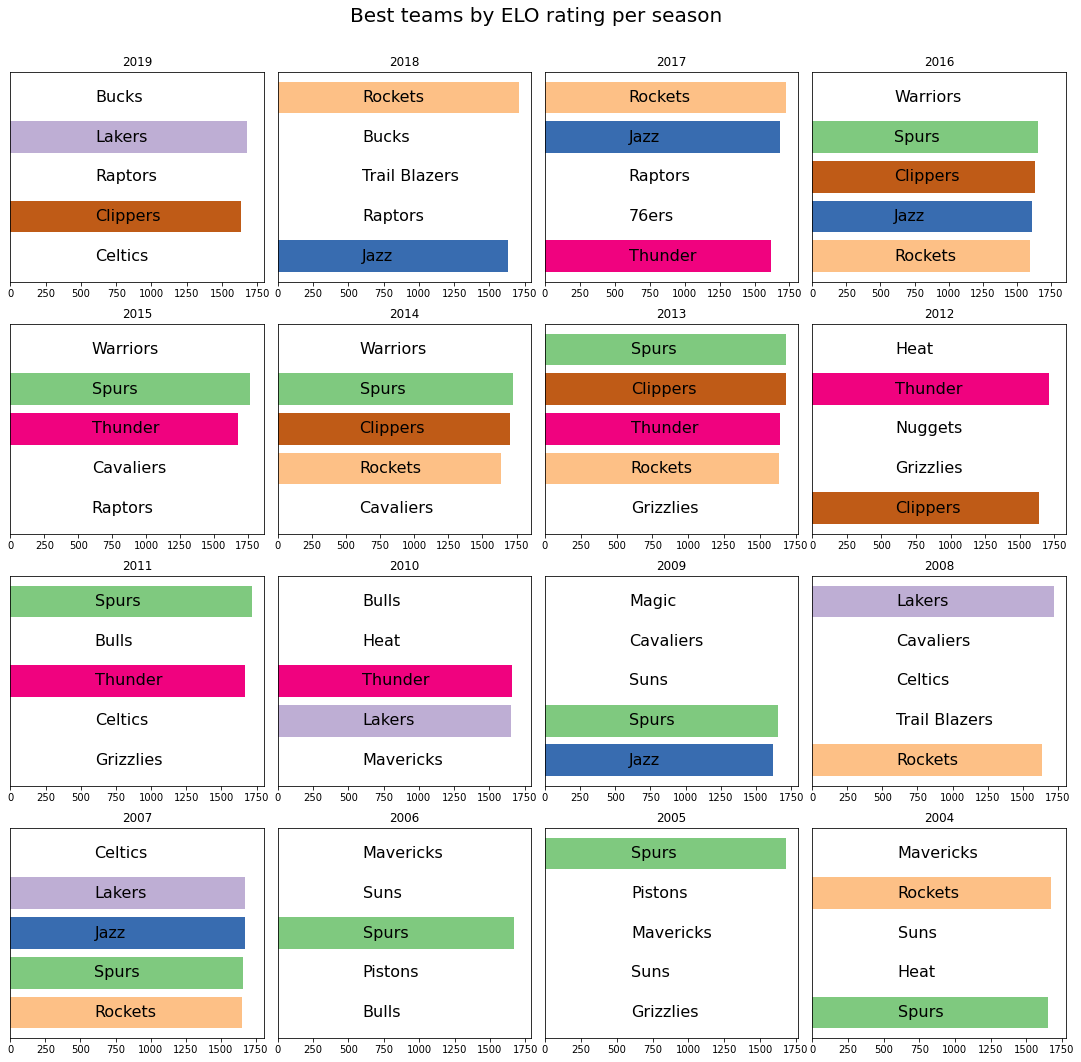

In [10]:
fig,axes = plt.subplots(4, 4, figsize=(15,15))
for i,season in enumerate(range(elo_plot_df.SEASON.max(), elo_plot_df.SEASON.min(), -1)):
    data = elo_plot_df.loc[elo_plot_df.SEASON == season].sort_values(by='ELO')
    axes.ravel()[i].tick_params(left=False, labelleft = False)
    axes.ravel()[i].barh(y=data.NAME, width=data.ELO, color=data.NAME.map(color_dict))
    axes.ravel()[i].set_title(str(season))
    for j,name in enumerate(data.NICKNAME):
        axes.ravel()[i].text(s=name, x=600, y=j, color="black", verticalalignment="center",size=16)
        
fig.suptitle('Best teams by ELO rating per season', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

The ELO rating looks in line with the results of the respective seasons. The most consistent teams in terms of seasons in the top 5 have their own colour. It becomes evident that the Spurs have dominated the last 15 years and are consistently one of the best teams in the league. (Hopefully they will rise again!🤞)  
I found also very interesting that out of the most consistent teams only the Lakers and the Spurs have actually won a championship in those years. Jazz, Rockets, Thunder and Clippers have yet to win the 🏆

Note that the ELO rating was calculated only based on regular season results and not playoff success. This becomes more important in later seasons as teams do load management and have understood that having their players healthy and rested in the playoffs is more important than a couple of ranking spots in the regular season.


## Incorporating player efficiency

Basketball is a sport where key players can have substantial impact on the team's success. Therefore, it is crucial to incorporate this information in the modelling dataset.  
This sounds straightforward in theory but in practice there is an important issue to be adressed: **There is no all-encompassing metric for efficiency in basketball**. 
The most popular one is the [Player efficiency rating (PER)](https://en.wikipedia.org/wiki/Player_efficiency_rating) developed by John Hollinger.  
Given that not all figures that are required in the calculation are available in the dataset, a different efficiency measure was used: (taken from [Breakthroughbasketball](https://www.breakthroughbasketball.com/stats/definitions.html))  
**Efficiency = Pts + Rebs + Ast + Stl + Blk – (TO + FG Misses + FT Misses)**  
One benefit that I found in this statistic is that it does filter for games played as the number of all of these figures increases with more games. This means that there is no need for an arbitrary cut-off for season games. 
Using this efficiency measure the following features were added to the dataset:  
1) Players in a team that had a top 30 efficiency rating last season.  
2) A measure of "team" efficiency by summing the last season efficiency of all players per team per game

The player efficiency figures for the 2019 season can be seen below:


In [11]:
details['FGMISSES'] = details.FGA - details.FGM
details['FTMISSES'] = details.FTA - details.FTM
details['EFF'] = details.PTS + details.REB + details.AST + details.STL + details.BLK - (details.TO + details.FGMISSES + details.FTMISSES)

# Creating the efficiency dataset
eff = details[['PLAYER_NAME', 'PLAYER_ID', 'SEASON', 'EFF']].copy()
eff.dropna(inplace=True)
eff = eff.groupby(['PLAYER_NAME', 'PLAYER_ID', 'SEASON'], as_index=False).sum()
eff.sort_values('EFF', ascending=False, inplace=True)
top_players = eff.groupby('SEASON', as_index=False).head(30).copy()
top_players['NEXT_SEASON'] = top_players.SEASON + 1
eff['NEXT_SEASON'] = eff.SEASON + 1

# Efficiency per game per team
per_game_eff = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(eff, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
pge = per_game_eff.groupby(['GAME_ID', 'TEAM_ID'], as_index=False).EFF.mean()
pge.dropna(inplace= True)

# Top players based on efficiecy for the 2019 season
top_players.loc[top_players.SEASON == 2019, ['PLAYER_NAME', 'EFF']]

,PLAYER_NAME,EFF
2787,Giannis Antetokounmpo,1985.0
3333,James Harden,1937.0
5908,Nikola Jokic,1834.0
4848,LeBron James,1804.0
2952,Hassan Whiteside,1700.0
2187,Domantas Sabonis,1662.0
471,Anthony Davis,1659.0
4979,Luka Doncic,1642.0
6713,Rudy Gobert,1636.0
630,Bam Adebayo,1630.0


It can be beneficial to investigate which are the top players according to the efficiency statistic for the 2019 season to get a feel for how well it filters the top players of the league.
For the 2019 season the results look quite reasonable, as most of the players selected in the top 30 are some of the best in the league. There are cases that looked strange to me, for example Hassan Whiteside and Andre Drummond but they are both included also in the [top PER ratings](http://insider.espn.com/nba/hollinger/statistics/_/year/2020) by Hollinger himself.

In [12]:
top_players_per_game = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(top_players, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')

top_players_per_game = top_players_per_game.groupby(['GAME_ID', 'TEAM_ID', 'SEASON_x']).PLAYER_NAME.agg(lambda x: x.notnull().sum()).reset_index()
top_players_per_game.columns = ['GAME_ID', 'TEAM_ID', 'SEASON', 'TOP_PLAYERS']
top_players_per_game.drop(columns='SEASON', inplace=True)

## Incorporating team fatigue

Players are humans and do get tired throughout the season. In order to measure this in the dataset the following variables are added:
* HG_7days: Home games in the last 7 days
* AG_7days: Away games in the last 7 days
* G_7days: Total games in the last 7 days
* BACK2BACK: Whether a team played a game the night before

In [13]:
games_played = pd.melt(games_short, id_vars = ['GAME_ID', 'GAME_DATE_EST'], value_vars = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']).set_index('GAME_DATE_EST')
games_played['HOME_GAME'] = np.where(games_played.variable == "HOME_TEAM_ID", True, False)
games_played.drop(columns = 'variable', inplace = True)
games_played.rename(columns = {'value':'TEAM_ID'}, inplace = True)
games_played.sort_values(['TEAM_ID', 'GAME_DATE_EST'], inplace = True)

# Games in the last week
games_played['HG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: x.rolling(window = "7d", closed='left', min_periods=0).sum())
games_played['AG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: (~x).rolling(window = "7d", closed='left', min_periods=0).sum())
games_played['G_7days'] = games_played['HG_7days'] + games_played['AG_7days']

# Back to back games
games_played.reset_index(inplace=True)
games_played['PAST_GAME'] = games_played.groupby(['TEAM_ID']).GAME_DATE_EST.transform(lambda x: x.shift(periods=1))
games_played['BACK2BACK'] = np.where((games_played.GAME_DATE_EST - games_played.PAST_GAME).dt.days == 1, 1, 0)
games_played.drop(columns = ['PAST_GAME', 'GAME_DATE_EST', 'HOME_GAME'], inplace=True)



## Missing players

In the details dataset there is a field called `comment` which indicates the reason a player is absent for the game. Unfortunately, this figure is not filled in for long-term injuries (for example for Kevin Durant in the 2019 season) but it can be used to calculate how many day-to-day injuries a team has in a given game.

In [14]:
missing_players = details.groupby(['GAME_ID', 'TEAM_ID'], as_index=False)['COMMENT'].agg(lambda x: ((x.notnull()) & (~x.str.contains('coach', case=False, na=False))).sum())
missing_players.rename(columns = {'COMMENT':'MISSING_PLAYERS'}, inplace = True)

In [15]:
# Combining all the data to create the full dataset
input_data = pd.merge_asof(games_short, ranking_short, left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE', 
                     left_by = 'HOME_TEAM_ID', right_by = 'TEAM_ID', allow_exact_matches = False)
input_data = input_data.loc[~input_data.TEAM_ID.isnull()]
input_data = pd.merge_asof(input_data, ranking_short.add_suffix("_VISITOR"), left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE_VISITOR', 
                     left_by = 'VISITOR_TEAM_ID', right_by = 'TEAM_ID_VISITOR', allow_exact_matches = False)

input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G > 50), ['G', 'W', 'L', 'HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = 0
input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G_VISITOR > 50), ['G_VISITOR', 'W_VISITOR', 'L_VISITOR', 'HOME_W_VISITOR', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR']] = 0

#Adding top players
input_data = input_data.merge(top_players_per_game, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(top_players_per_game, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding player efficiency
input_data = input_data.merge(pge, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(pge, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding team fatigue
input_data = input_data.merge(games_played, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(games_played, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding missing players
input_data = input_data.merge(missing_players, left_on=['GAME_ID', 'HOME_TEAM_ID'], right_on=['GAME_ID', 'TEAM_ID'])
input_data = input_data.merge(missing_players, left_on=['GAME_ID', 'VISITOR_TEAM_ID'], right_on=['GAME_ID', 'TEAM_ID'], suffixes=(None, '_VISITOR'))

# Adding ELO
input_data = input_data.merge(elo_data[['GAME_ID', 'HOME_ELO', 'VISITOR_ELO']])

input_data['HOME_TEAM'] = input_data['HOME_TEAM_ID'].map(teams_dict)
input_data['VISITOR_TEAM'] = input_data['VISITOR_TEAM_ID'].map(teams_dict)

input_data = input_data.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID', 'TEAM', 'TEAM_ID_x', 'TEAM_ID_y', 'STANDINGSDATE', 'TEAM_VISITOR', 'STANDINGSDATE_VISITOR'])
input_data['ELO_DIFF'] = input_data.HOME_ELO - input_data.VISITOR_ELO
input_data['TOP_PLAYER_DIFF'] = input_data.TOP_PLAYERS - input_data.TOP_PLAYERS_VISITOR
input_data['MISSING_PLAYER_DIFF'] = input_data.MISSING_PLAYERS - input_data.MISSING_PLAYERS_VISITOR
input_data['EFF_DIFF'] = input_data.EFF - input_data.EFF_VISITOR
input_data['MONTH'] = input_data.GAME_DATE_EST.dt.month

input_data.drop(columns = ['HOME_TEAM', 'VISITOR_TEAM', 'CONFERENCE', 'CONFERENCE_VISITOR', 'GAME_DATE_EST'], inplace=True)

## Splitting the data

The datasets are split as follows:  
1) A train set in order to train the classifier (all seasons after 2005 and before 2018)    
2) A validation set in order to tune the hyperparameters and evaluate feature selection  (2018 season)  
3) A test set in order to assess how well the classifier works out of sample (2019 season)

I did not include the 2020 season as it would require some careful recalibration of multiple parameters such as:
* Player availability due to Covid
* Empty stadiums
* Season starting right after the playoffs finished

In [16]:
train_data = input_data.loc[(input_data.SEASON < 2018) & (input_data.SEASON > 2005)]
valid_data = input_data.loc[input_data.SEASON == 2018]
test_data = input_data.loc[input_data.SEASON == 2019]
full_train_data = pd.concat([train_data, valid_data], axis = 0)

X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
valid_X, valid_y = valid_data.drop(columns = ['HOME_TEAM_WINS']), valid_data.HOME_TEAM_WINS
test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

train_games = X[['SEASON', 'GAME_ID']]
valid_games = valid_X[['SEASON', 'GAME_ID']]
test_games = test_X[['SEASON', 'GAME_ID']]

X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
valid_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)
test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

# Game predictions

Given the data at our disposal let's try to see how well we can predict the outcome of the games in the 2019 season. In order to take full advantage of the dataset, we are going to tune the parameters based on the validation set and after selecting the optimal ones we are going to retrain the model on the validation and train set before making the final predictions.  
For generating the predictions we are going to use [CatBoost](https://catboost.ai/) a very popular gradient boosting library.

## Naive prediction

Before starting to do feature selection, modelling or any other calculation, we need to establish what is the baseline accuracy for our predictions. Two relatively simple ways of predicting the outcome came to mind:  
*1) The outcome of the game will be the same as the outcome of the previous encounter between the same teams*  
For example, if the Miami Heat are playing the Lakers the naive prediction would be to predict that the result of the game will be the same as the result of the previous encounter between those two teams.  
*2) The home team will win. Generally, the home team does have a statistical advantage in the NBA (as in most sports)*

Given that both these options are reasonable, let's try both of them out and pick the one that scores the highest as the prediction benchmark.

In [17]:
def calc_accuracy(model, test_X, test_y):
    return(np.round(accuracy_score(model.predict(test_X), test_y)*100,2))
    
def add_accuracy(model, model_name, test_X, test_y):
    test_acc = calc_accuracy(model, test_X, test_y)
    results_l.append([model_name, test_acc, len(test_X.columns)])
    print(model_name + ' test accuracy: ' + str(test_acc) + ' %')
    
results_l = []

In [18]:
games_short.sort_values("GAME_DATE_EST", inplace=True)
naive = pd.merge_asof(games_short, games_short[['GAME_DATE_EST', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS']], on = 'GAME_DATE_EST', by = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID'], allow_exact_matches = False, suffixes=(['', '_p']))
naive = naive.dropna()

print('Same result prediction accuracy: ' + str(np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2)) + ' %')
print('Home team wins prediction accuracy: ' + str(np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2)) + ' %')

results_l.append(['Same result', np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2), 1])
results_l.append(['Home team wins', np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2), 0])


Same result prediction accuracy: 58.18 %
Home team wins prediction accuracy: 59.25 %


## ELO only prediction

The ELO rating of the two teams is a very good predictor of match results (as we shall see also later on in the notebook). How accurate would the predictions be if we only relied on the ELO of the two teams?

In [19]:
print('ELO accuracy: ' + str(np.round(accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100,2)) + ' %')
results_l.append(['ELO', accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100, 1])

ELO accuracy: 64.91 %


## Full Catboost model

One of the selling points of `CatBoost` is that the model can achieve high accuracy without much parameter tuning. Let's see how that works for the NBA dataset.

| ➕      | ➖ |
| ----------- | ----------- |
| Easy to train      |   Features that negatively impact the accuracy of the model are not removed     |
| Uses all the features from the dataset   | Low model interpretability|

In [20]:
catb = CatBoostClassifier(verbose=False)
catb.fit(full_train_X, full_train_y)
add_accuracy(catb, 'Full model', test_X, test_y)

Full model test accuracy: 67.6 %


## Using SHAP values to understand predictions

After obtaining a basic model, we can use it to understand how predictions are made by using the SHAP values. It is important to note that SHAP values offer prediction explanations for individual examples. An appropriate interpretation of the values is the following:  
 > Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.  [Interpretable ML book](https://christophm.github.io/interpretable-ml-book/shap.html)

The first game in the validation dataset is the game between the [Brooklyn Nets and the Detroit Pistons](https://www.youtube.com/watch?v=ch5G4fGvXaE).

In [21]:
games['HOME_TEAM'] = games.HOME_TEAM_ID.map(teams_dict)
games['VISITOR_TEAM'] = games.VISITOR_TEAM_ID.map(teams_dict)

games.loc[games.GAME_ID == valid_games.GAME_ID.iloc[0], ['GAME_DATE_EST', 'HOME_TEAM', 'VISITOR_TEAM', 'PTS_home', 'PTS_away']]

,GAME_DATE_EST,HOME_TEAM,VISITOR_TEAM,PTS_home,PTS_away
18923,2018-10-17,DET,BKN,103.0,100.0


In [22]:
explainer = shap.TreeExplainer(catb)
shap_values = explainer.shap_values(valid_X)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,], valid_X.iloc[0,:])

The SHAP values indicate that the model was considering Detroit slightly bigger favourite than the base value (the fact that the base value is higher than 0 indicates that the model has understood that the home team has the advantage generally).  
The main feature in favour of Detroit winning was the ELO difference between the two teams (biggest red components). On the other hand, the fact that two players were not available for Detroit pushed in the opposite direction (biggest blue component).

The second game in the validation dataset is the game between the [Indiana Pacers and the Memphis Grizzlies](https://www.youtube.com/watch?v=cAP5Lqppqwg). None of the two teams had dramatic changes in their lineups in the offseason that would flip the balance of power. In the actual game Indiana crushed the Grizzlies to almost 30 points difference.

In [23]:
games.loc[games.GAME_ID == valid_games.GAME_ID.iloc[1], ['GAME_DATE_EST', 'HOME_TEAM', 'VISITOR_TEAM', 'PTS_home', 'PTS_away']]

,GAME_DATE_EST,HOME_TEAM,VISITOR_TEAM,PTS_home,PTS_away
18924,2018-10-17,IND,MEM,111.0,83.0


In [24]:
shap.force_plot(explainer.expected_value, shap_values[1,], valid_X.iloc[1,:])

The drivers of the model prediction are the difference between the ELO rating of the two teams and their efficiency. The model is very confident in the prediction that home team would win the game, which indeed it did.  


Even from these two examples we can see that there are lots of features that are not contributing that much to the prediction, while there are some that contribute quite significantly. In the next parts of the notebook we are going to try to see if we can achieve similar accuracy by reducing the features of the model.

# Feature selection

In any machine learning model feature selection is very important in order to use only the most useful features and remove useless ones. This can help the model generalise better for new input data. This becomes clear also from looking at the SHAP charts above where very few variables are the main drivers of the decisions while the rest are contributing very little.

There are multiple ways of doing feature selection:
* Using a statistical test to determine features that are related to the output variable 
* Using permutation importance to select the most relevant features
* Using the feature importance of the model to remove less important features
* Using the SHAP values importance

In the following parts of the notebook, we are going to try all those options. Please note that for more accurate results, a wider choice of grid search could be selected but in the interest of time (and lack of patience 😅) the parameter selection was limited.


## Simple filtering

The simplest approach to take, calculating how well each feature is separating the output (win or loss) and selecting the top features. The approach is using an ANOVA test to determine a measure of separation of the dependent variable for each feature. This is a really [nice post](https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w) explaining it in more detail.

| ➕      | ➖ |
| ----------- | ----------- |
| Relatively quick to calculate      |   Missing interactions and more complicated relationships     |
| Easy to understand and explain selection  | |

In order to better explain the drawback of the method, imagine a scenario where 1 variable is very predictive for a small number of observations in the dataset. For example in the NBA scenario, let's say that all other things being equal, the team that has a back to back game is less likely to win. This separation will come into play for that particular subset of games (small) where the teams are evenly matched. But the `Back to back` feature is not very predictive for the dataset as a whole and therefore it will score low overall.

In [25]:
pipe = Pipeline([
    ('reduce_dim', SelectKBest(f_classif)),
    ('classify', CatBoostClassifier(verbose=False))
])

param_grid = [
      { 'reduce_dim__k': [8, 10, 12],
        'classify__depth':[3, 5, 7]}]

sf_grid = GridSearchCV(pipe, n_jobs=-1, param_grid=param_grid)
_ = sf_grid.fit(X, y)

### Which are the features that were selected from the GridSearch model?  
We can find it by checking the best parameters of the grid.

In [26]:
features_selected = sf_grid.best_params_['reduce_dim__k']
print("The GridSearch selected " + str(features_selected) + ' features with a tree depth of ' + str(sf_grid.best_params_['classify__depth']))
feature_score_df = pd.DataFrame({'Feature':X.columns, 'Score':sf_grid.best_estimator_['reduce_dim'].scores_}).sort_values(by='Score', ascending=False).head(features_selected)
feature_score_df

The GridSearch selected 12 features with a tree depth of 3


,Feature,Score
30,ELO_DIFF,2425.228961
28,HOME_ELO,1283.338661
33,EFF_DIFF,1089.245580
29,VISITOR_ELO,1023.540762
31,TOP_PLAYER_DIFF,829.002071
17,EFF_VISITOR,537.108961
14,TOP_PLAYERS,433.529237
15,TOP_PLAYERS_VISITOR,392.709689
16,EFF,341.086078
5,AWAY_W,328.987385


In [27]:
full_train_X_sf = full_train_X[feature_score_df.Feature]
sf_model = CatBoostClassifier(verbose=False)
sf_model.fit(full_train_X_sf, full_train_y)

test_X_sf = test_X[feature_score_df.Feature]
add_accuracy(sf_model, 'Simple filtering', test_X_sf, test_y)

Simple filtering test accuracy: 64.19 %


## Permutation importance

The idea behind permutation importance for a single feature is very simple:  
1) Calculate the overall error of the model  
2) Shuffle the values of the feature randomly in order to break any association between the feature and the outcome  
3) Calculate by how much does the error of the model change with the new shuffling

Higher values would mean that the feature was important for the predictions of the model.

| ➕      | ➖ |
| ----------- | ----------- |
| Easy to implement      |   Issues with capturing more complex relationships in the data     |
| Easy to understand and explain   | Can lead to impossible combinations | 

The first issue of the method is very similar to the simple filtering case. The second requires some further explanation:
In the NBA data scenario, we have three ELO related variables, ELO home, ELO visitor, ELO Diff (difference between home and visitor ELO). If we do a permutation of the ELO Diff variable, the permutation will lead to some impossible combinations where we have for example ELO Home 1500, ELO visitor 1500 and ELO Diff 200 just because we selected the ELO Diff values randomly.


In [28]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    best_valid_acc = 0
    for features in [8, 10, 12]:
        for depth in [3,5,7]:
            pi_catb = CatBoostClassifier(verbose=False, depth=depth)
            perm = PermutationImportance(estimator=pi_catb, cv=3).fit(X.reset_index(drop=True), y.reset_index(drop=True))
            selected_columns = X.columns[np.argpartition(perm.feature_importances_, -features)[-features:]].tolist()

            valid_X_pi = valid_X[selected_columns]
            pi_catb.fit(X[selected_columns], y)

            valid_acc = np.round(accuracy_score(pi_catb.predict(valid_X_pi), valid_y),3)
            if valid_acc > best_valid_acc:
                pi_features = selected_columns
                pi_depth = depth
                best_valid_acc = valid_acc    

full_train_X_pi = full_train_X[pi_features]
test_X_pi = test_X[pi_features]
pi_model = CatBoostClassifier(verbose=False, depth=pi_depth)
pi_model.fit(full_train_X_pi, full_train_y)

The features selected by the permutation importance calculation are the following:

In [29]:
pd.DataFrame(pi_features[::-1], columns = ['Features'])

,Features
0,HOME_W_VISITOR
1,EFF_DIFF
2,MISSING_PLAYER_DIFF
3,AWAY_L_VISITOR
4,ELO_DIFF
5,W_VISITOR
6,HOME_ELO
7,MISSING_PLAYERS_VISITOR
8,HOME_L_VISITOR
9,EFF


Efficiency appears to be the most important feature with ELO and missing players being in the top 5. There are quite some differences in the last spots compared to the simple filtering algorithm but we have to see how these translate in the model's ability to generalise:

In [30]:
add_accuracy(pi_model, 'Permutation importance', test_X_pi, test_y)

Permutation importance test accuracy: 66.15 %


## Feature importance

By feature importance in the context of a boosting tree, what is meant is the following:
How effective (in terms of reducing the loss or node impurity) are the splits based on each particular attribute?
There are multiple factors to take into account here:
* The effectiveness is weighted by the number of observations at each split so splits that occur higher up the tree are more impactful (the lower we get on the decision tree the less observations there are to be split)
* The number of trees that is using an attribute for a split is important here. More trees using the attribute for a split --> Higher score for the attribute

| ➕      | ➖ |
| ----------- | ----------- |
| Can capture more complex relationships      |   Collinearity in the data might confound actual feature importance     |
| Effective and efficient   | | 


Luckily, CatBoost has a built-in method for doing feature selection that allows using the feature importance as a selection criterion. The method includes Recursive Feature Elimination which starts with a model using the full set of features, calculates the feature importance and eliminates the least important of the features

In [31]:
train_pool = Pool(X, y)
best_valid_acc = 0

for features in [8, 10, 12]:
    for depth in [3, 5, 7]:
        fi_catb = CatBoostClassifier(verbose=False, depth = depth)
        summary = fi_catb.select_features(X=train_pool, 
                                features_for_select=X.columns.to_list(),
                                num_features_to_select = features,
                                steps = 3,
                                logging_level='Silent',
                                train_final_model=True,
                                algorithm = 'RecursiveByLossFunctionChange',
                                plot=False)
        valid_acc = np.round(accuracy_score(fi_catb.predict(valid_X), valid_y),3)
        if valid_acc > best_valid_acc:
            fi_model = fi_catb
            fi_depth = depth
            fi_features = summary['selected_features_names']
            best_valid_acc = valid_acc

full_train_X_fi = full_train_X[fi_features]
test_X_fi = test_X[fi_features]
fi_model = CatBoostClassifier(verbose=False, depth=fi_depth)
fi_model.fit(full_train_X_fi, full_train_y)

The features selected based on RFE and feature importance are again mostly focused on the efficiency and the ELO rating of the two teams. 

In [32]:
pd.DataFrame(fi_features[::-1], columns = ['Features'])

,Features
0,EFF_DIFF
1,MISSING_PLAYER_DIFF
2,ELO_DIFF
3,VISITOR_ELO
4,HOME_ELO
5,EFF_VISITOR
6,EFF
7,HOME_W
8,L
9,G


In [33]:
add_accuracy(fi_model, 'Feature importance', test_X_fi, test_y)

Feature importance test accuracy: 66.05 %


## SHAP importance

The last algorithm for feature selection is selection by SHAP values. The idea behind the algoritm is fairly similar to the feature importance algorithm above with the only difference being that instead of selecting the features that result in the biggest decrease in losses, we select the features that have on average the highest SHAP values.



In [34]:
train_pool = Pool(X, y)

valid_acc = 0

for features in [8, 10, 12]:
    for depth in [3, 5, 7]:
        si_catb = CatBoostClassifier(verbose=False, depth = depth)
        summary = si_catb.select_features(X=train_pool, 
                                features_for_select=X.columns.to_list(),
                                num_features_to_select = features,
                                steps = 3,
                                logging_level='Silent',
                                algorithm = 'RecursiveByShapValues',
                                train_final_model=True,
                                plot=False)
        valid_acc = np.round(accuracy_score(si_catb.predict(valid_X), valid_y),3)
        if valid_acc > best_valid_acc:
            si_depth = depth
            si_features = summary['selected_features_names']
            best_valid_acc = valid_acc
 

Despite the change in the way that the values are selected, the selected features do not differ substantially between the Feature importance and the SHAP importance selection.

In [35]:
pd.DataFrame(si_features[::-1], columns=['Features'])

,Features
0,EFF_DIFF
1,MISSING_PLAYER_DIFF
2,ELO_DIFF
3,VISITOR_ELO
4,HOME_ELO
5,EFF_VISITOR
6,EFF
7,L_VISITOR
8,L
9,G


In [36]:
full_train_X_si = full_train_X[si_features]
test_X_si = test_X[si_features]
si_model = CatBoostClassifier(verbose=False, depth=si_depth)
si_model.fit(full_train_X_si, full_train_y)

add_accuracy(si_model, 'Shap importance', test_X_si, test_y)

Shap importance test accuracy: 66.46 %


# Evaluating the results

We have tried various predictive strategies and it can be good to put together all the scores for each of the methods.



In [37]:
pd.DataFrame(results_l, columns = ['Model name', 'Test accuracy', 'Features']).sort_values(by='Test accuracy', ascending=False)

,Model name,Test accuracy,Features
3,Full model,67.600000,35
7,Shap importance,66.460000,10
5,Permutation importance,66.150000,10
6,Feature importance,66.050000,10
2,ELO,64.912281,1
4,Simple filtering,64.190000,12
1,Home team wins,59.250000,0
0,Same result,58.180000,1


The full model with all the features available achieves the best test accuracy. Nevertheless the feature selection methods (especially the Permutation and Shap importance ones) achieve comparable accuracy with significantly smaller number of features. 

Now comes the important part: **How good is the model?**  
Unfortunately, there is no clear answer to this as we do not know exactly what kind of accuracy can be achieved. I could not find any models that try to predict regular season games (most focus on the playoffs which are significantly more predictable). But we can do some assessment!
Does the model improve on the floor accuracy?  
1) The model is better than the baseline ✅  
2) The model is better than simple ELO based predictions ✅

**How high is the accuracy ceiling?**  
The easiest answer to this question is that an all omnicient being can predict with 100% accuracy and therefore that is the ceiling. A more realistic answer would be to try to see *how much inherent unpredictability is there in the NBA*.  
The most reliable source of data I could find for this is this perfectly named paper [Luck is hard to beat](https://arxiv.org/pdf/1706.02447.pdf). The researchers performed an analysis accross all sports to try and understand to what extent does luck play a role in the results.  
For basketball the skill coefficient is pretty high as it is a high scoring game which gives plenty of opportunity for the highly skilled teams to shine. They did however perform an analysis accross the NBA regular season to see **how often an underdog wins the game**. The figure they came up with (average accross seasons 2012-2016) is **around 36% of the time**. This gives us a figure of roughly speaking the unpredictability of the regular season.  
Please note that despite the analysis in this paper, there are always improvements to be made in any prediction algorithm!

## Lessons learnt

Analysing and working with this dataset took quite a while and resulted in many (but really many!😂) unsuccessful attempts. These have been educational as I learnt some valuable lessons that might be useful for somebody who is relatively new to predictive modelling. I think these points are mostly relevant for someone trying to establish a good model and not aiming to get that extra 0.01 increase in accuracy that will push their submission to the top of the leaderboard.

**1) Before anything establish a reasonable baseline to measure the model against**    
**2) Understanding which parts of the data are useful for prediction is crucial, start out by training simple models on the data that you are interested in and then focus on the parts that show most promise**  
**3) Feature engineering is crucial and good features will get you much much further than hyperparameter tuning. This is really important as hyperparameter tuning is relatively straightforward (simply try out values) but feature engineering requires putting much more thought into the issue and understanding the data better**

# Resources

PER: https://en.wikipedia.org/wiki/Player_efficiency_rating  
NBA ELO: https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/#:~:text=One%20hundred%20Elo%20points%20is,and%20then%20divide%20by%2028  
Chess ELO https://en.wikipedia.org/wiki/Elo_rating_system  
Luck is hard to beat: https://arxiv.org/pdf/1706.02447.pdf  
Model interpretability: https://christophm.github.io/interpretable-ml-book
CatBoost: https://catboost.ai/